/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (0.31651841229383865, 0.3892599391249885)
torch.Size([2, 9, 120, 120])


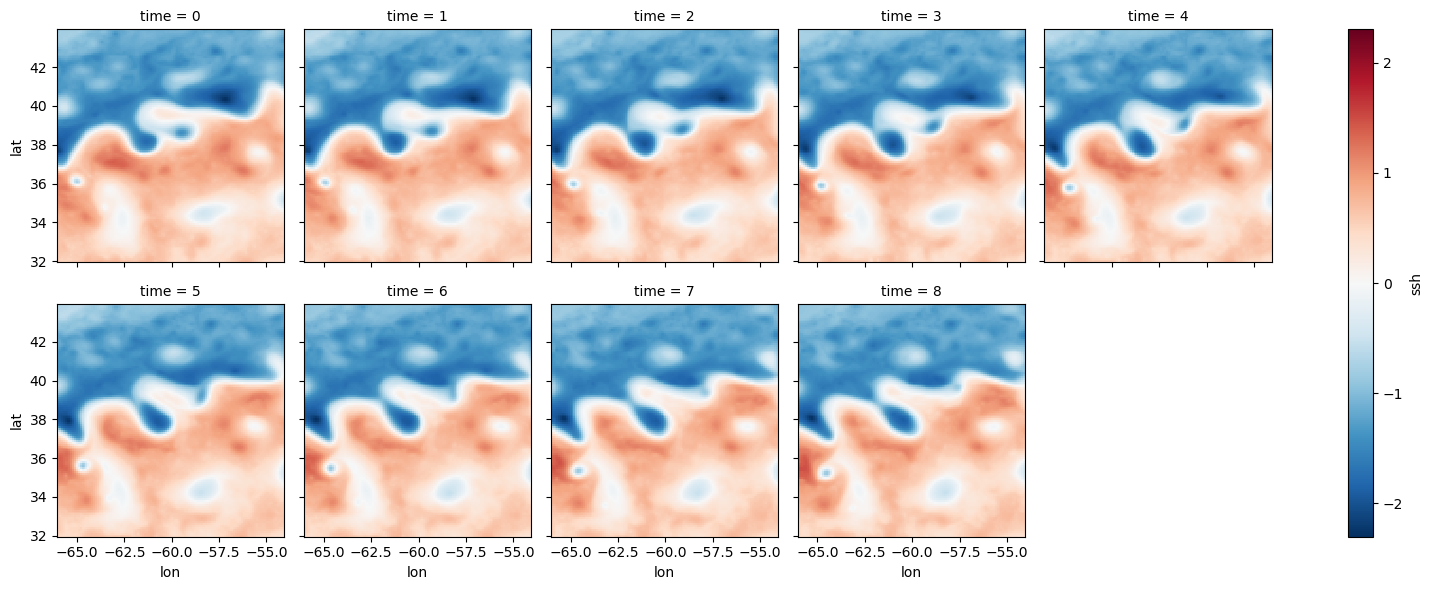

In [1]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *
from contrib.stoch_spde.lit_model_spde import *
from contrib.stoch_spde.models_spde import *
#from contrib.stoch_spde.solver import *
#from contrib.stoch_spde.unet import *

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35

datamodule = BaseDataModule(input_da=load_altimetry_data("../data/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2, grad=False)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

torch.Size([2, 2, 9, 120, 120])


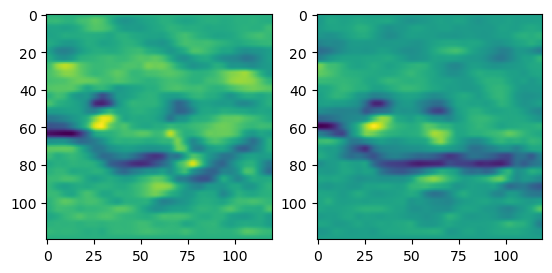

In [2]:
import pandas as pd
import einops

def interpolate_na_2D(da, max_value=100.):
    return (
            da.where(np.abs(da) < max_value, np.nan)
            .pipe(lambda da: da)
            .to_dataframe()
            .interpolate(limit_direction='both')
            .pipe(xr.Dataset.from_dataframe)
    )

y = my_sample[0]
def init_fields(obs):
    n_b, n_t, n_y, n_x = y.shape
    y_xr = xr.Dataset(data_vars={'ssh':(('batch','time','lat','lon'),obs)},
                      coords={'batch':np.arange(n_b),
                              'time':np.arange(n_t),
                              'lon':np.arange(n_x),
                              'lat':np.arange(n_y)})
    ybis =  interpolate_na_2D(y_xr.mean(dim='time'))
    ybis =  ybis.coarsen(lon=4, boundary="trim").mean().coarsen(lat=4, boundary="trim").mean()
    ybis = einops.repeat(torch.tensor(ybis.ssh.data), 'b m n -> b k m n', k=9)
    m = torch.nn.Upsample(scale_factor=4, mode='bilinear')  # align_corners=False
    ybis = m(ybis)
    qg_veloc = kfilts.spatial_gradient(ybis,normalized=True)
    qg_veloc = torch.permute(qg_veloc,(0,2,1,3,4))
    return qg_veloc
    
qg_veloc = init_fields(y)
print(qg_veloc.shape)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(qg_veloc[0,1,4,:,:])
ax2.imshow(qg_veloc[1,1,4,:,:])

# Define the solver

## 1. BilinAE

In [3]:
class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

## 2. PriorNet

In [4]:
class PriorNet(torch.nn.Module):
    def __init__(self, dim_in,  dim_hidden, nparam, kernel_size=3, downsamp=None):

        super().__init__()

        self.nt = dim_in
        self.nparam = nparam
        self.dim_param = self.nt * nparam
        #self.dim_hidden_param = dim_hidden*self.dim_param
        self.dim_hidden_param = 100
        self.bilin_quad = False

        # state estimation
        self.conv_in = torch.nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_1 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = torch.nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_out = torch.nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        # parameter estimation
        self.conv_in_param = torch.nn.Conv2d(
            self.dim_param, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden_param = torch.nn.Conv2d(
            self.dim_hidden_param, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.add_grad_info = torch.nn.Conv2d(
            self.dim_hidden_param + 3*self.nt, self.dim_hidden_param, kernel_size=kernel_size, padding=kernel_size // 2
        )

        # rebuild the augmented state
        self.aug_conv_out = torch.nn.Conv2d(
            dim_in + self.dim_hidden_param, dim_in + self.dim_param, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = torch.nn.AvgPool2d(downsamp) if downsamp is not None else torch.nn.Identity()
        self.up = (
            torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else torch.nn.Identity()
        )

    def forward(self, state):

        n_b, _, n_y, n_x = state.shape
        state = self.down(state)

        # state estimation
        x = self.conv_in(state[:,:self.nt,:,:])
        x = self.conv_hidden(F.relu(x))
        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )

        # parameter estimation
        theta = self.conv_in_param(state[:,self.nt:,:,:])
        theta = self.conv_hidden_param(F.relu(theta))
        theta = self.add_grad_info(torch.cat([x, 
                                              torch.reshape(kfilts.spatial_gradient(x,normalized=True),
                                                            (n_b, 2*self.nt, n_y, n_x)),
                                              theta], dim=1))

        # final state
        state = self.aug_conv_out(
            torch.cat([x, theta], dim=1)
        )
        state = self.up(state)
        return state

class AugPriorCost(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, nparam, kernel_size=3, downsamp=None):

        super().__init__()
        self.nt = dim_in
        self.priornet = PriorNet(dim_in, dim_hidden, nparam, kernel_size, downsamp)

    def forward_ae(self, x):
        x = self.priornet(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

## 3. Solver

In [5]:
import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GradSolver_Lgv(nn.Module):
    def __init__(self, nll, nlpobs, prior_cost, obs_cost, grad_mod, n_step,
                 lr_grad=0.2, exclude_params=False, aug_state=False, unet_prior=False, **kwargs):
        super().__init__()
        self.nll = nll
        self.nlpobs = nlpobs
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.unet_prior = unet_prior
        self.grad_mod = grad_mod
        self.n_step = n_step
        self.lr_grad = lr_grad
        self.exclude_params = exclude_params
        self._grad_norm = None
        self.aug_state = aug_state
        self.lambda_obs = torch.nn.Parameter(torch.Tensor([1.]))
        self.lambda_reg = torch.nn.Parameter(torch.Tensor([1.]))
        
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const

    def interpolate_na_2D(self, da, max_value=100.):
        return (
            da.where(np.abs(da) < max_value, np.nan)
            .pipe(lambda da: da)
            .to_dataframe()
            .interpolate(limit_direction='both')
            .pipe(xr.Dataset.from_dataframe)
        )

    def init_fields(self, obs):
        n_b, n_t, n_y, n_x = obs.shape
        y_xr = xr.Dataset(data_vars={'ssh':(('batch','time','lat','lon'),obs.detach().cpu())},
                      coords={'batch':np.arange(n_b),
                              'time':np.arange(n_t),
                              'lon':np.arange(n_x),
                              'lat':np.arange(n_y)})
        ybis =  self.interpolate_na_2D(y_xr.mean(dim='time'))
        ybis =  ybis.coarsen(lon=4, boundary="trim").mean().coarsen(lat=4, boundary="trim").mean()
        ybis = einops.repeat(torch.tensor(ybis.ssh.data), 'b m n -> b k m n', k=5)
        m = torch.nn.Upsample(scale_factor=4, mode='bilinear')  # align_corners=False
        ybis = m(ybis)
        qg_veloc = kfilts.spatial_gradient(ybis,normalized=True)
        qg_veloc = torch.permute(qg_veloc,(0,2,1,3,4))
        return qg_veloc

    def init_state(self, batch, x_init=None):
        
        if self.aug_state==False:
            if x_init is not None:
                return x_init
            else:
                return batch.input.nan_to_num().detach().requires_grad_(True)
        else:
            # augmented state
            qg_veloc = self.init_fields(batch.input.detach()).to(device)
            
            kappa_init = torch.ones(batch.input.size()).to(device)*0.1
            tau_init = torch.ones(batch.input.size()).to(device)*0.1
            m1_init = torch.ones(batch.input.size()).to(device)*0.1
            m2_init = torch.ones(batch.input.size()).to(device)*0.1
            #m1_init = qg_veloc[:,0,:,:,:]
            #m2_init = qg_veloc[:,1,:,:,:]
            vx_init = torch.zeros(batch.input.size()).to(device)
            vy_init = torch.zeros(batch.input.size()).to(device)
            gamma_init = torch.ones(batch.input.size()).to(device)
            beta_init = torch.zeros(batch.input.size()).to(device)

            if x_init is None:
                x_init = batch.input.nan_to_num().detach()
            state_init =  torch.cat((x_init,
                                kappa_init,
                                tau_init,
                                m1_init,
                                m2_init,
                                vx_init,
                                vy_init,
                                gamma_init,
                                beta_init),dim=1).requires_grad_(True)
            return state_init

    def solver_step(self, state, batch, step, mu=None, noise=False):
        device = state.device
        n_b, n_t, n_y, n_x = batch.input.shape
        #self.cnn = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn2 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn3 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn4 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        if self.aug_state==False:
            x = state
            theta = None
        else:
            x = state[:,:n_t,:,:]
            theta = state[:,n_t:,:,:]
        if not self.unet_prior:
            grad_logp = torch.nanmean(self.lambda_obs**2 * self.nlpobs(x,batch) + \
                                          self.lambda_reg**2 * (-1) * self.nll(x, theta, mu=mu, det=False))
        else: 
            qg_veloc = torch.permute(kfilts.spatial_gradient(x,normalized=True),(0,2,1,3,4))
            qg_veloc_x = qg_veloc[:,0,:,:,:] 
            qg_veloc_y = qg_veloc[:,1,:,:,:] 
            #m1_cost = F.mse_loss(self.cnn(theta[:,(2*n_t):(3*n_t),:,:]),self.cnn2(qg_veloc_x))
            #m2_cost = F.mse_loss(self.cnn3(theta[:,(3*n_t):(4*n_t),:,:]),self.cnn4(qg_veloc_y))
            #m1_cost = F.mse_loss(theta[:,(2*n_t):(3*n_t),:,:],qg_veloc_x)
            #m2_cost = F.mse_loss(theta[:,(3*n_t):(4*n_t),:,:],qg_veloc_y)
            grad_logp = self.lambda_obs**2 * self.obs_cost(x, batch) +\
                        self.lambda_reg**2 * self.prior_cost(state,exclude_params=self.exclude_params) #+ 
                        #m1_cost + m2_cost

        grad = torch.autograd.grad(grad_logp, state, create_graph=True)[0]

        # B,t,x,y -> b,t,y,x
        # add noise
        if noise:
            noise = torch.randn(grad.size(),requires_grad=True).to(device) #* self.lr_grad
            gmod = self.grad_mod(grad + noise)
        else:
            gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state_update = 1 / (step + 1) * gmod

        res = state - state_update #+ noise

        if self.aug_state==True:
            # parameters: kappa > 0
            kappa = res[:,n_t:(2*n_t),:,:]
            kappa = F.relu(kappa)+.01
            res = torch.index_add(res,1,torch.arange(n_t,2*n_t).to(device),-1*res[:,n_t:(2*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(n_t,2*n_t).to(device),kappa)

            # parameters: tau > 0
            tau = res[:,(2*n_t):(3*n_t),:,:]
            tau = F.relu(tau)+.1
            res = torch.index_add(res,1,torch.arange(2*n_t,3*n_t).to(device),-1*res[:,(2*n_t):(3*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(2*n_t,3*n_t).to(device),tau)

            # parameters: gamma > 0
            gamma = res[:,(7*n_t):(8*n_t),:,:]
            gamma = F.relu(gamma)+.01
            res = torch.index_add(res,1,torch.arange(7*n_t,8*n_t).to(device),-1*res[:,(7*n_t):(8*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(7*n_t,8*n_t).to(device),gamma)

            # parameters: beta > 0
            beta = res[:,(8*n_t):(9*n_t),:,:]
            beta = F.relu(beta)+.01
            res = torch.index_add(res,1,torch.arange(8*n_t,9*n_t).to(device),-1*res[:,(8*n_t):(9*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(8*n_t,9*n_t).to(device),beta)
            
            """
            vxy = res[:,(5*n_t):(7*n_t),:,:]
            vxy = self.custom_sigmoid(vxy,min=-3,max=3)
            res = torch.index_add(res,1,torch.arange(5*n_t,7*n_t).to(device),-1*res[:,(5*n_t):(7*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(5*n_t,7*n_t).to(device),vxy)
            """
            
        return res
        
    def forward(self, batch, x_init = None, mu=None, reshape_theta=True):

        device = batch.input.device
        n_t = batch.input.size(1)
        
        with torch.set_grad_enabled(True):
            state = self.init_state(batch, x_init=x_init)
            self.grad_mod.reset_state(batch.input)

            for step in range(self.n_step):
                state = self.solver_step(state, batch, mu=mu, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)

        if self.aug_state == False:
            theta = None
        else:
            theta = state[:,n_t:,:,:]
            state = state[:,:n_t,:,:]
            if reshape_theta:
                kappa, m, H, tau = self.nll.reshape_params(theta)
                theta = [kappa, m, H, tau]
        
        return state, theta

class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.dropout = torch.nn.Dropout(dropout)
        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

## 4. NLL

In [6]:
def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size).to(device)
    if len(val.size())==0:
        values = (val.expand(size)).to(device)
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])).to(device)

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.LongTensor(size*n1,size*n2).to(device)


class Encoder(torch.nn.Module):

    def __init__(self,shape_data):
        super(Encoder, self).__init__()
        self.n_t, self.n_y, self.n_x  = shape_data
        self.cnn = torch.nn.Conv2d(self.n_t,8*self.n_t,(3,3),padding=1,bias=False)

    def forward(self, x):
        # input shape (b,t,y,x) --> output shape (b,7*t,y,x)
        theta = self.cnn(x)
        # activation functions on some parameters
        return theta

class NLL_new(torch.nn.Module):

    def __init__(self, shape_data, st_lag=[1,1,1], pow=1, spde_type="adv_diff", crop=None):

        super(NLL_new,self).__init__()
        self.spde_type = spde_type
        self.pow = pow
        self.crop = crop
        if crop is not None:
            shape_data = [shape_data[0],
                          shape_data[1]-self.crop,
                          shape_data[2]-self.crop]
        self.encoder = Encoder(shape_data)
        self.operator_spde = Prior_SPDE(shape_data,st_lag,pow=self.pow,spde_type=self.spde_type)

    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const
        
    def reshape_params(self,theta):

        n_b, n_t, n_x, n_y = theta.shape
        n_t = theta.shape[1]//8

        # reshape the parameters
        kappa = theta[:,:n_t,:,:]
        tau = theta[:,n_t:2*n_t,:,:]
        m1 = theta[:,2*n_t:3*n_t,:,:]
        m2 = theta[:,3*n_t:4*n_t,:,:]
        vx = theta[:,4*n_t:5*n_t,:,:]
        vy = theta[:,5*n_t:6*n_t,:,:]
        gamma = theta[:,6*n_t:7*n_t,:,:]
        beta = theta[:,7*n_t:8*n_t,:,:]
        
        H = []
        for k in range(n_t):
            vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
            vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
            vxy = torch.stack([vx_,vy_],dim=2)
            vxyT = torch.permute(vxy,(0,2,1))
            gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
            beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
            H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
            H.append(H_)
        H = torch.stack(H,dim=4)
        m = torch.stack([m1,m2],dim=1)

        kappa = torch.permute(kappa,(0,2,3,1))
        tau = torch.permute(tau,(0,2,3,1))
        m = torch.permute(m,(0,1,3,4,2))
        H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
        H = torch.permute(H,(0,1,2,3,4,5))

        # reshaping n_x,n_y -> n_x*n_y
        kappa = torch.reshape(kappa,(n_b,1,n_y*n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y*n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y*n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y*n_x,n_t))

        #H = torch.full(H.shape,0.).to(device)
        return [kappa, m, H, tau]

    def forward(self, x, theta=None, mu=None, det=True):

        n_b, n_t, n_x, n_y = x.shape

        # compute the parameters
        if theta is None:
            theta = self.encoder(x)
            
        if not isinstance(theta, list):
            kappa, m, H, tau = self.reshape_params(theta)
        else:
            kappa, m, H, tau = theta
        
        # compute Q(theta)
        if self.crop is not None:
            c = self.crop//2
            x = x[:,:,c:-c,c:-c]
            mu = mu[:,:,c:-c,c:-c]
            kappa = torch.reshape(torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            tau = torch.reshape(torch.reshape(tau,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            m = torch.reshape(torch.reshape(m,(n_b,2,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            H = torch.reshape(torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))[:,:,:,c:-c,c:-c,:],
                                   (n_b,2,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            n_b, n_t, n_x, n_y = x.shape
            
        Q, block_diag = self.operator_spde(kappa,
                                           m,
                                           H,
                                           tau,
                                           store_block_diag=True)
        
        for i in range(n_b):
            #0print(Q[i])
            Q[i] = pow_diff_operator(Q[i],pow=self.pow*2-1,sparse=True)
            #print(Q[i])
        
        # compute determinant(Q)
        if det==True:
            det_Q = list()
            for i in range(n_b):
                log_det = 0.
                for j in range(1,len(block_diag[i])):
                    #BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                    #chol_block = torch.linalg.cholesky(BD)
                    info = torch.tensor(1)
                    k = 0
                    while (info!=0):          
                        BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                        chol_block, info = torch.linalg.cholesky_ex(BD)
                        pow = -7+k
                        BD = ((1./2)*(BD+BD.t())).add_(torch.eye(BD.shape[0]).to(device)*(1**pow))
                        k = k+1
                        if k>=5:
                            return torch.tensor([np.nan for _ in range(n_b)])
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         chol_block,
                                         0)\
                                        )\
                                       )
                    '''
                    l = torch.linalg.eigvals(BD)
                    minl = torch.min(torch.Tensor([i.type(torch.cuda.FloatTensor) for i in l]))
                    maxl = torch.max(torch.Tensor([i.type(torch.cuda.FloatTensor) for i in l]))
                    print(minl, maxl, maxl/minl)
                    '''
                    '''
                    import gpytorch
                    L_block = gpytorch.pivoted_cholesky(BD, rank=BD.shape[0])
                    print(L_block)
                    #BD = block_diag[i][j].detach() #+ sparse_eye(BD.shape[0],torch.tensor(0.01))
                    #chol_block = cholesky_sparse.apply(BD.cpu()).to_dense()
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         L_block,
                                         0)\
                                        )\
                                       )
                    '''
                    '''
                    P, L, U = torch.linalg.lu(BD, pivot=True)
                    nswaps = len(torch.diagonal(P,0)) - torch.sum(torch.diagonal(P,0)) - 1
                    print(nswaps)
                    print(torch.sum(torch.log(torch.diagonal(L,0))))
                    print(torch.sum(torch.log(torch.diagonal(U,0))))
                    log_det_block = torch.log( (-1)**nswaps) + \
                                    torch.sum(torch.log(torch.diagonal(L,0)))+ \
                                    torch.sum(torch.log(torch.diagonal(U,0))) 
                    print(log_det_block)
                    '''
                    log_det += log_det_block
                det_Q.append(log_det)

        # compute Mahanalobis distance xT.Q.x
        MD = list()
        for i in range(n_b):
            if mu is None:
                MD_ = sp_mm(Q[i],torch.reshape(x[i],(n_t*n_x*n_y,1)))
                MD_ = torch.matmul(torch.reshape(x[i],(1,n_t*n_x*n_y)),MD_)
            else:
                MD_ = sp_mm(Q[i],torch.reshape(x[i]-mu[i],(n_t*n_x*n_y,1)))
                MD_ = torch.matmul(torch.reshape(x[i]-mu[i],(1,n_t*n_x*n_y)),MD_)
            MD.append(MD_[0,0])

        # Negative log-likelihood
        if det==True:
            log_det = torch.stack(det_Q)
        MD = torch.stack(MD)

        # NLL is -log[p_theta(x)] has size (#batch,1)
        # GradNLL (with autodiff) will have same dim as x
        if det==True:
            NLL = -1.*(log_det - MD)
        else:
            NLL = -1.*MD

        return NLL

In [7]:
device = 'cuda'

# state + param
solver = GradSolver_Lgv(aug_state=True,
                      n_step=10,
                      lr_grad=1e-3,
                      exclude_params=False,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time'],120,120],
                                                           pow=2, spde_type="adv_diff", crop = 20),
                      nlpobs = NLpObs(),
                      prior_cost = BilinAEPriorCost(dim_in=81,dim_hidden=162,
                                                                               bilin_quad=False,downsamp=2,
                                                                               nt=datamodule.xrds_kw['patch_dims']['time']),
                      #prior_cost = AugPriorCost(dim_in=9, dim_hidden=32, nparam=8),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=81,dim_hidden=244),
                      #unet_prior = False).to(device)
                      unet_prior = True).to(device)

# state only
solver2 = GradSolver_Lgv(aug_state=False,
                      n_step=10,
                      lr_grad=1e-3,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time'],120,120],
                                                           pow=2, spde_type="adv_diff", crop = 20),
                      nlpobs = NLpObs(),
                      prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=32,
                                                    bilin_quad=False,downsamp=2,
                                                    nt=datamodule.xrds_kw['patch_dims']['time']),
                      #prior_cost = AugPriorCost(dim_in=9, dim_hidden=32, nparam=8),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=9,dim_hidden=44),
                      unet_prior = True).to(device)

# param only
solver3 = BilinAEPriorCost(dim_in=81,dim_hidden=162,
                           bilin_quad=False,downsamp=2,
                           nt=datamodule.xrds_kw['patch_dims']['time'])  

# Training

In [8]:
rec_weight = get_triang_time_wei(patch_dims = datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset= 1)
rec_weight = torch.from_numpy(rec_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    loss, out, theta = base_step(batch)
    # MSE grad loss
    grad_loss = weighted_mse( kfilts.sobel(out) - kfilts.sobel(batch.tgt), rec_weight)
    _, theta_nrs = solver(batch, reshape_theta = False)
    prior_cost = solver.prior_cost(solver.init_state(batch, torch.cat((out, theta_nrs), dim=1)),
                                            exclude_params=True)
    training_loss = 50 * loss  + 2000 * grad_loss + 1.0 * prior_cost

    if epoch>=1:
        if solver.aug_state==True:
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = theta,
                                                 #mu = out,
                                                 det=True))
        else:
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = solver.nll.encoder(out),
                                                 det=True))
        if torch.isnan(nll_loss)==True:
            return None, None
        training_loss += nll_loss * 1e-6
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4) 
        ax1.imshow(batch.tgt[0,4,:,:].detach().cpu())
        ax2.imshow(out.detach().cpu()[0,4,:,:])
        ax3.imshow(solver.init_fields(batch.input.detach()).cpu()[0,1,4,:,:])
        ax4.imshow(np.reshape(theta[1].detach().cpu()[0,1,:,4],(120,120)))
        plt.show()
        
        print(50 * loss  + 2000 * grad_loss + 1.0 * prior_cost, nll_loss*1e-6)
    
    return training_loss, out

def base_step(batch):
    out, theta = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, rec_weight)
    return loss, out, theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
 
def cosanneal_spde_lr_adam(lr, T_max=100, weight_decay=0.):
    opt = torch.optim.Adam(
        [
            {"params": solver.grad_mod.parameters(), "lr": lr},
            {"params": solver.nll.parameters(), "lr": lr},
            {"params": solver.nlpobs.parameters(), "lr": lr / 2},
        ], weight_decay=weight_decay
    )
    return {
        "optimizer": opt,
        "lr_scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=T_max),
    }

optimizer = cosanneal_spde_lr_adam(lr, T_max=100)
optimizer = optimizer['optimizer']

optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])

start = 0
if start>=1:
    ckpt = torch.load('ckpt_spde_wonll.pth', map_location=device)
    solver.load_state_dict(ckpt)
tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    y, x = batch
    batch = batch._replace(input=batch.input.to(device))
    batch = batch._replace(tgt=batch.tgt.to(device))
    loss, out = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
  # Update the checkpoint after each epoch of training.
  if epoch>=1: 
      torch.save(solver.state_dict(), 'ckpt_spde_wnll.pth')
  else:
      torch.save(solver.state_dict(), 'ckpt_spde_wonll.pth')

# Training (disjoint)

In [9]:
rec_weight = get_triang_time_wei(patch_dims = datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)

rec_weight = torch.from_numpy(rec_weight).to(device)

downsamp = 8
down = torch.nn.AvgPool2d(downsamp)
up = torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    loss, out, theta = base_step(batch)
    grad_loss = weighted_mse( kfilts.sobel(out) - kfilts.sobel(batch.tgt), rec_weight)
    prior_cost = solver2.prior_cost(solver2.init_state(batch, out))
    training_loss = 50*loss  + 2000 * grad_loss + 1.0 * prior_cost
    #print(50*loss, 2000 * grad_loss, 1.0 * prior_cost)
    
    if epoch>=50:
        if solver.aug_state==True:
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = theta,
                                                 mu = up(down(out)),
                                                 det=True))
        else:
            nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = solver.nll.encoder(out),
                                                 det=True))
        if torch.isnan(nll_loss)==True:
            return None, None
        training_loss += nll_loss * 1e-8
        
        '''
        '''
        fig, axs = plt.subplots(2, 7,figsize=(50,10)) 
        gt = axs[0,0].imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(gt, ax=axs[0,0])
        inp = axs[0,1].imshow(solver2(batch=batch)[0][0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(inp, ax=axs[0,1])
        output = axs[0,2].imshow(out.detach().cpu()[0,4,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(output, ax=axs[0,2])
        output_c = axs[0,3].imshow(up(down(out)).detach().cpu()[0,4,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(output_c, ax=axs[0,3])
        diff = axs[0,4].imshow((out-up(down(out))).detach().cpu()[0,4,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
        plt.colorbar(diff, ax=axs[0,4])
        kappa = axs[1,0].imshow(np.reshape(theta[0].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(kappa, ax=axs[1,0])
        m1 = axs[1,1].imshow(np.reshape(theta[1].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(m1, ax=axs[1,1])
        m2 = axs[1,2].imshow(np.reshape(theta[1].detach().cpu()[0,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(m2, ax=axs[1,2])
        H11 = axs[1,3].imshow(np.reshape(theta[2].detach().cpu()[0,0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(H11, ax=axs[1,3])
        H12 = axs[1,4].imshow(np.reshape(theta[2].detach().cpu()[0,0,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(H12, ax=axs[1,4])
        H22 = axs[1,5].imshow(np.reshape(theta[2].detach().cpu()[0,1,1,:,4],(120,120)),aspect='auto')
        plt.colorbar(H22, ax=axs[1,5])
        tau = axs[1,6].imshow(np.reshape(theta[3].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
        plt.colorbar(tau, ax=axs[1,6])
        fig.delaxes(axs[0][5])
        fig.delaxes(axs[0][6])
        plt.show()
        '''
        '''
        print(50 * loss  + 2000 * grad_loss + 1.0 * prior_cost, nll_loss*1e-6)
    
    return training_loss, out

def base_step(batch):

    out, theta = solver2(batch=batch)
    if epoch>=50:
        #out, theta = solver(batch=batch, x_init=out)
        #out, theta = solver(batch=batch, 
        #                    x_init=torch.full(out.shape,0.).to(device),
        #                    mu=out)
        # provide mu as coarse version of 4DVarNet outputs
        mean = up(down(out))
        out, theta = solver(batch=batch, 
                            x_init=out,
                            mu=mean)
    # mse loss
    loss = weighted_mse(out - batch.tgt, rec_weight)
    return loss, out, theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
            {"params": solver2.parameters(), "lr": lr},
        ])

start = 50
reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_spde_wonll.pth', map_location=device)
    solver2.load_state_dict(ckpt)
    #ckpt = torch.load('ckpt_spde_wnll.pth', map_location=device)
    #solver.load_state_dict(ckpt)
    
tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).nan_to_num().to(device))
    loss, out = step(batch)
    
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)

  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5)) 
  gt = ax1.imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(gt, ax=ax1)
  inp = ax2.imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
  plt.colorbar(inp, ax=ax2)
  inp = ax3.imshow(out[0,4,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5) 
  plt.colorbar(inp, ax=ax3)
  plt.show()
    
  # Update the checkpoint after each epoch of training.
  if epoch<50: 
      torch.save(solver2.state_dict(), '../ckpt/ckpt_spde_wonll.pth')
  else:
      torch.save(solver.state_dict(), '../ckpt/ckpt_spde_wnll.pth')

# Training (simplifié)

In [ ]:
rec_weight = get_triang_time_wei(patch_dims = datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset= 1)
rec_weight = torch.from_numpy(rec_weight).to(device)

solver2 =  torch.nn.Conv2d(9,72,(3,3),padding=1,bias=False).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    theta = base_step(batch)
    nll_loss = torch.nanmean(solver.nll(batch.tgt,
                                                 theta = solver.nll.reshape_params(theta),
                                                 det=True))
    if torch.isnan(nll_loss)==True:
        return None
    training_loss = nll_loss * 1e-6
    
    theta = solver.nll.reshape_params(theta)
        
    fig, axs = plt.subplots(2, 7,figsize=(50,10)) 
    gt = axs[0,0].imshow(batch.tgt[0,4,:,:].detach().cpu(),aspect='auto')
    plt.colorbar(gt, ax=axs[0,0])
    inp = axs[0,1].imshow(batch.input[0,4,:,:].detach().cpu(),aspect='auto')
    plt.colorbar(inp, ax=axs[0,1])
    m1_init = axs[0,2].imshow(solver.init_fields(batch.input.detach()).cpu()[0,0,4,:,:],aspect='auto')
    plt.colorbar(m1_init, ax=axs[0,2])
    m2_init = axs[0,3].imshow(solver.init_fields(batch.input.detach()).cpu()[0,1,4,:,:],aspect='auto')
    plt.colorbar(m2_init, ax=axs[0,3])
    kappa = axs[1,0].imshow(np.reshape(theta[0].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
    plt.colorbar(kappa, ax=axs[1,0])
    m1 = axs[1,1].imshow(np.reshape(theta[1].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
    plt.colorbar(m1, ax=axs[1,1])
    m2 = axs[1,2].imshow(np.reshape(theta[1].detach().cpu()[0,1,:,4],(120,120)),aspect='auto')
    plt.colorbar(m2, ax=axs[1,2])
    H11 = axs[1,3].imshow(np.reshape(theta[2].detach().cpu()[0,0,0,:,4],(120,120)),aspect='auto')
    plt.colorbar(H11, ax=axs[1,3])
    H12 = axs[1,4].imshow(np.reshape(theta[2].detach().cpu()[0,0,1,:,4],(120,120)),aspect='auto')
    plt.colorbar(H12, ax=axs[1,4])
    H22 = axs[1,5].imshow(np.reshape(theta[2].detach().cpu()[0,1,1,:,4],(120,120)),aspect='auto')
    plt.colorbar(H22, ax=axs[1,5])
    tau = axs[1,6].imshow(np.reshape(theta[3].detach().cpu()[0,0,:,4],(120,120)),aspect='auto')
    plt.colorbar(tau, ax=axs[1,6])
    fig.delaxes(axs[0][4])
    fig.delaxes(axs[0][5])
    fig.delaxes(axs[0][6])
    plt.show()
        
    print(nll_loss*1e-6)
    
    return training_loss

def base_step(batch):
    
    n_b, n_t, n_y, n_x = batch.tgt.shape
    res = solver2(batch.tgt.to(device))
    
    # parameters: kappa > 0
    kappa = res[:,0*n_t:(1*n_t),:,:]
    kappa = F.relu(kappa)+.01
    res = torch.index_add(res,1,torch.arange(0*n_t,1*n_t).to(device),-1*res[:,0*n_t:(1*n_t),:,:])
    res = torch.index_add(res,1,torch.arange(0*n_t,1*n_t).to(device),kappa)

    # parameters: tau > 0
    tau = res[:,(1*n_t):(2*n_t),:,:]
    tau = F.relu(tau)+.1
    res = torch.index_add(res,1,torch.arange(1*n_t,2*n_t).to(device),-1*res[:,(1*n_t):(2*n_t),:,:])
    res = torch.index_add(res,1,torch.arange(1*n_t,2*n_t).to(device),tau)

    # parameters: gamma > 0
    gamma = res[:,(6*n_t):(7*n_t),:,:]
    gamma = F.relu(gamma)+.01
    res = torch.index_add(res,1,torch.arange(6*n_t,7*n_t).to(device),-1*res[:,(6*n_t):(7*n_t),:,:])
    res = torch.index_add(res,1,torch.arange(6*n_t,7*n_t).to(device),gamma)

    # parameters: beta > 0
    beta = res[:,(7*n_t):(8*n_t),:,:]
    beta = F.relu(beta)+.01
    res = torch.index_add(res,1,torch.arange(7*n_t,8*n_t).to(device),-1*res[:,(7*n_t):(8*n_t),:,:])
    res = torch.index_add(res,1,torch.arange(7*n_t,8*n_t).to(device),beta)
        
    return res

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

n_epochs =  50#@param {'type':'integer'}
lr = 1e-3 #@param {'type':'number'}

optimizer = torch.optim.Adam(
        [
            {"params": solver2.parameters(), "lr": lr},
        ])

start = 0

tqdm_epoch = tqdm(range(start,start+n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    y, x = batch
    batch = batch._replace(input=batch.tgt.to(device))
    batch = batch._replace(tgt=batch.tgt.to(device))
    loss = step(batch)
    optimizer.zero_grad() 
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)
  # Update the checkpoint after each epoch of training.
  if epoch>=1: 
      torch.save(solver2.state_dict(), 'ckpt_spde_wnll.pth')
  else:
      torch.save(solver2.state_dict(), 'ckpt_spde_wonll.pth')

# Test

In [ ]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_spde_wonll.pth', map_location=device)
solver2.load_state_dict(ckpt)
#ckpt = torch.load('../ckpt/ckpt_spde_wnll.pth', map_location=device)
#solver.load_state_dict(ckpt)

k = 10
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

test_batch = test_batch._replace(input=torch.unsqueeze(test_batch.input[0],0).to(device))
test_batch = test_batch._replace(tgt=torch.unsqueeze(test_batch.tgt[0],0).to(device))
out, _ = solver2(test_batch)
#out, theta = solver(test_batch, x_init=out)
mean = up(down(out))
out, theta = solver(test_batch, 
                    x_init=out,
                    mu=mean)

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[:,4,:,:].detach().cpu())},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot()#(col='time')
plt.show()
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[:,4,:,:].detach().cpu())},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot()#(col='time')
plt.show()
xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.reshape(theta[2][:,1,1,:,4].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.plot()#(col='time')
plt.show()
xr.Dataset(data_vars={'m1':(('time','lat','lon'),np.reshape(theta[1][:,0,:,4].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).m1.plot()#(col='time')
plt.show()
xr.Dataset(data_vars={'tau':(('time','lat','lon'),np.reshape(theta[3][:,0,:,4].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).tau.plot()#(col='time')
plt.show()
xr.Dataset(data_vars={'kappa':(('time','lat','lon'),np.reshape(theta[0][:,0,:,4].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).kappa.plot()#(col='time')
clear_output(wait=True) 
plt.show()
#print(x_estim.shape)

In [ ]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

def run_simulation(i,tau,M,x,dx,dy,dt,n_init_run=10):
    nb_nodes = M.shape[0]
    regul = (tau*np.sqrt(dt))/(dx*dy)
    val = cupy.fromDlpack(to_dlpack(M.coalesce().values().data))
    ind = cupy.fromDlpack(to_dlpack(M.coalesce().indices().data))
    M_ = cupy_sp_csc_matrix((val,ind),shape=(M.size()[0],M.size()[0]))
    # if i==0: start stability run
    if i==0:
        xi = torch.randn(nb_nodes).to(device)
        for i in range(n_init_run):
            random = torch.randn(nb_nodes).to(device)
            RM = torch.mul(regul,random)+torch.flatten(xi)
            RM_ = cupy.fromDlpack(to_dlpack(RM))
            xi_ = cupy_spsolve(M_, RM_)
            xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
            #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)     
    else:
        random = torch.randn(nb_nodes).to(device)
        RM = torch.mul(regul,random)+torch.flatten(x[i-1])
        RM_ = cupy.fromDlpack(to_dlpack(RM))
        xi_ = cupy_spsolve(M_, RM_)
        xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
        #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)
    xi.requires_grad = True
    xi = torch.flatten(xi)
    x.append(xi)
    return x

theta[0] = torch.full(theta[0].shape,0.33).to(device)
theta[1] = torch.full(theta[1].shape,0.).to(device)
theta[2][:,0,0,:,:] = torch.full(theta[2][:,0,0,:,:].shape,1).to(device)
theta[2][:,0,1,:,:] = torch.full(theta[2][:,0,1,:,:].shape,1).to(device)
theta[2][:,1,0,:,:] = torch.full(theta[2][:,1,0,:,:].shape,1).to(device)
theta[2][:,1,1,:,:] = torch.full(theta[2][:,1,1,:,:].shape,1).to(device)
theta[3] = torch.full(theta[3].shape,1.).to(device)

n_b, n_t, n_y, n_x = out.shape
nb_nodes = n_x*n_y
dx = dy = dt = 1

# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)
pow=1
spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],pow=pow,spde_type='adv_diff')
Q = spde(theta[0],theta[1],theta[2],theta[3],
                             store_block_diag=False)

for i in range(n_b):
    #0print(Q[i])
    Q[i] = pow_diff_operator(Q[i],pow=pow*2-1,sparse=True)
    #print(Q[i])

x_simu = []
for ibatch in range(n_b):
    x_simu_ = []
    '''
    for it in range(n_t):
        print(it)
        A = DiffOperator_old(n_x,
                                     n_y,
                                     dx,
                                     dy,
                                     theta[1][ibatch,:,:,it],
                                     theta[2][ibatch,:,:,:,it],
                                     theta[0][ibatch,:,:,it])
        M = I+pow_diff_operator(A,pow=4,sparse=True)
        x_simu_ = run_simulation(it,theta[3][ibatch,0,:,it],M,
                                                  x_simu_,dx,dy,dt,n_init_run=10)
    x_simu_ = torch.stack(x_simu_,dim=0)
    ''' 
    Q_ = Q[ibatch]
    Q_ = spspmm(Q[ibatch],Q[ibatch])
    print(Q_)
    Q_sp = sparse_torch2scipy(Q_.detach().cpu())
    print(type(Q_sp))
    
    factor = cholesky(Q_sp,ordering_method='natural')
    x_simu_ = torch.FloatTensor(factor.solve_Lt(torch.randn(nb_nodes*n_t))).to(device)
    x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y))
    x_simu.append(x_simu_)
x_simu = torch.stack(x_simu,dim=0).to(device)

# interpolate the simulation based on LSTM-solver
inputs_simu = x_simu.clone()
inputs_obs_simu = x_simu.clone()
mask = test_batch.input.isfinite()
inputs_obs_simu[~mask] = 0.
# create simu_batch 
simu_batch = test_batch
simu_batch = simu_batch._replace(input=inputs_obs_simu)
simu_batch = simu_batch._replace(tgt=inputs_simu)
#x_itrp_simu, _ = solver(batch=simu_batch)
x_itrp_simu, _ = solver2(simu_batch)
#x_itrp_simu, theta = solver(simu_batch, x_init=x_itrp_simu.detach())
mean = up(down(out))
x_itrp_simu, theta = solver(simu_batch, 
                            x_init=x_itrp_simu,
                            mu=mean)
x_itrp_simu = x_itrp_simu.detach()

# conditional simulation
x_simu_cond = out+(x_simu-x_itrp_simu)

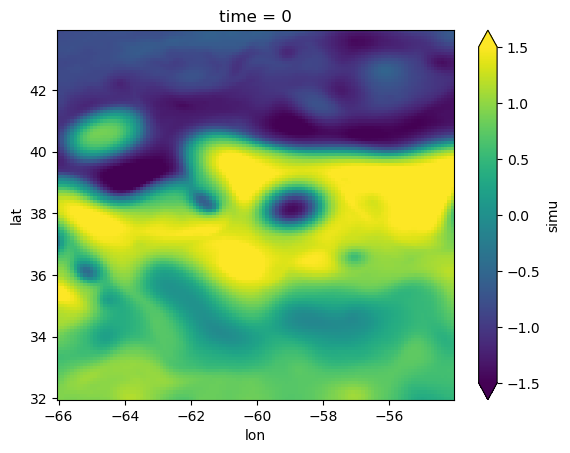

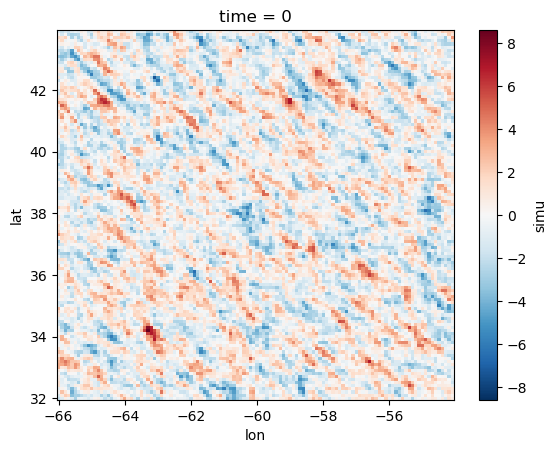

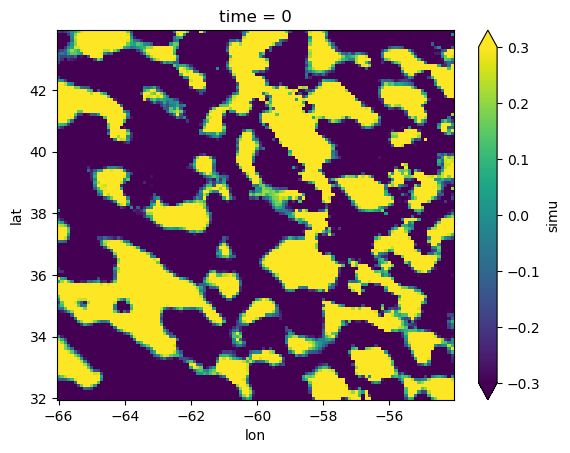

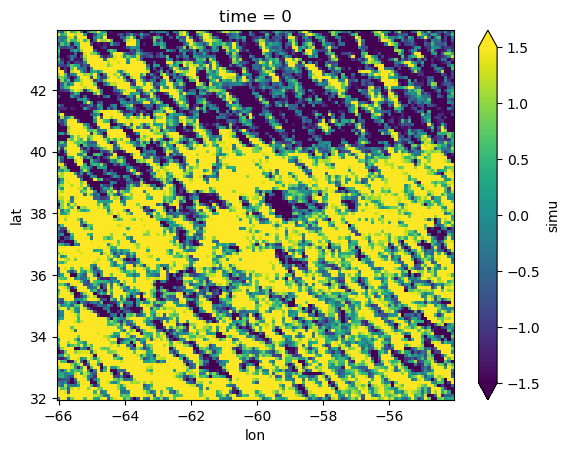

In [38]:
from IPython.display import clear_output

xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(test_batch.tgt[:,4,:,:].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(vmin=-1.5,vmax=1.5)#col='time')#
clear_output(wait=True)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:,7,:,:].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot()#vmin=-1,vmax=1)#col='time')#
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_itrp_simu[:,4,:,:].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(vmin=-.3,vmax=.3)#col='time')#
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu_cond[:,4,:,:].detach().cpu(),(1,120,120)))},
           coords={'time':np.arange(1),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(vmin=-1.5,vmax=1.5)#col='time')#
plt.show()